In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [10]:
# pathlib.Path is just a smarter, cross-platform file name—handling slashes, joins, etc
DATA_PATH = Path('insurance.csv')
df = pd.read_csv(DATA_PATH)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.info()
# Notice: No missing values, ['sex', 'smoker', 'region'] are objects (strings) and should become categories

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


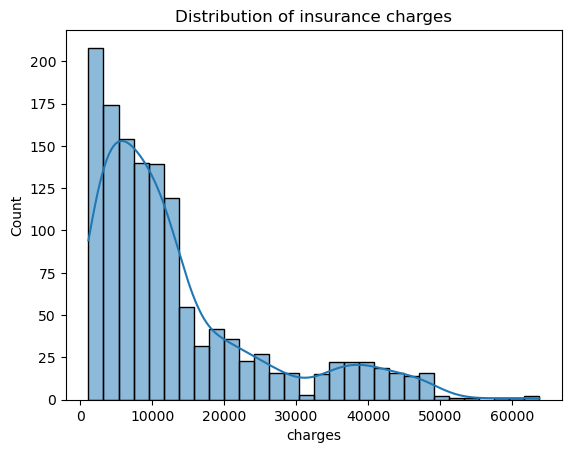

In [8]:
# Quick plots (doesn't cause data leakage)
sns.histplot(df['charges'], kde = True)
plt.title('Distribution of insurance charges')
plt.show()

# Notice
#     the graph is right-skewed with right long tail -> mean > median
#     it is widespread -> potential outliers -> higher risk when setting premiums

In [14]:
# Split dataset BEFORE calculating or dealing with outlers to avoid data leakage
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [37]:
# Dealing with outliers: log and z-score ON TRAIN SET ONLY

# --- Why use np.log1p(x) instead of np.log(x) ---
# • Adds 1 before taking the log, so zeros don’t blow up (log(0) = -inf).
# • Keeps every row: works for counts, prices, or charges that can be 0.
# • More precise than log(x + 1) for tiny values (NumPy special math).
# • If your data are all > 0 and never zero, plain np.log(x) is fine.
train_df['log_charges'] = np.log1p(train_df['charges'])
mean = train_df['log_charges'].mean()

# • .std() = standard deviation of the column.
# • ddof=0  → “population” version: divide by N (all rows).
#   (Default ddof=1 divides by N-1 for a sample.)
# • Calculation in three steps:
#   1) μ = average of log_charges
#   2) variance = Σ (x − μ)² / N
#   3) std      = √variance
std = train_df['log_charges'].std(ddof=0)

# Calculate z-score for every row
# • df["z_log"].abs()  → absolute distance from the mean in σ units.
# • > 3                → “beyond ±3 standard deviations.”
# • For a normal bell curve, only ~0.3 % of points lie past ±3σ,
#   so these rows are very unlikely and are flagged as potential outliers.
train_df['z_log'] = (train_df['log_charges'] - mean) / std
outlier_mask = train_df['z_log'].abs() > 3
outlier = train_df[outlier_mask]

# Print how many rows were flagged as outliers
# • f-string{} lets us embed a value inside the text.
# • outliers.shape[0] = number of rows in the DataFrame.
print(f"⚠️ Found {outlier.shape[0]} potential outliers")
display_cols = ["charges", "log_charges", "z_log"] + [c for c in train_df.columns if c not in ("charges","log_charges","z_log")]
print(outlier[display_cols].head())

⚠️ Found 0 potential outliers
Empty DataFrame
Columns: [charges, log_charges, z_log, age, sex, bmi, children, smoker, region]
Index: []


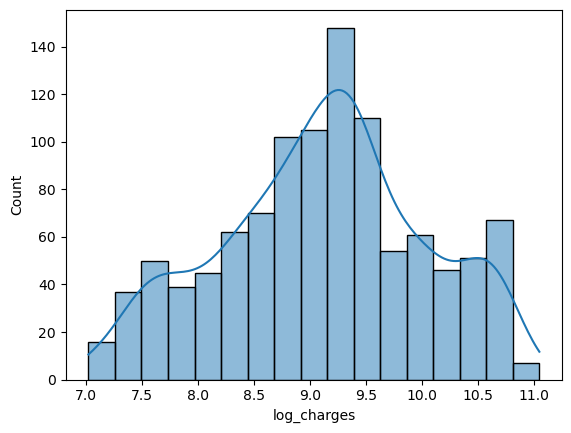

In [27]:
sns.histplot(train_df['log_charges'], kde = True)
plt.show()

In [30]:
# MANUAL get_dummies code

# # Store object-type columns as category type instead of plain text.
# # Behind the scenes each unique label is turned into a small integer code, so the column takes far less memory than storing the full strings.
# # Machine-learning ready – most ML algorithms accept only numbers.

# cat_cols = ['sex', 'smoker', 'region']
# train_df[cat_cols] = train_df[cat_cols].astype("category")

# # “Dummy” (one-hot) turns each text label into its own 0/1 column.
# #     smoker → smoker_yes  (1 = “yes”, 0 = “no”)
# #     region → region_south, region_west, …
# # Converts words to numbers without pretending one word is “bigger.”
# # drop_first=True  → skip the first dummy in every set
# #   • Avoids redundant columns that confuse linear/logistic models
# #   • A row of all zeros means the dropped label (info not lost)
# #   • For tree/boosting models you can leave all dummies (set False)

# train_df_dummies = pd.get_dummies(train_df, drop_first = True)

In [38]:
# Add the same 'log_charges' column to test_df
# The model is trained to predict log-scaled charges, so it must be judged on log-scaled charges.
test_df['log_charges'] = np.log1p(test_df['charges'])

In [39]:
cat_cols = ['sex', 'smoker', 'region']

# Create a list of numeric feature names only:  
# 1) drop all categorical columns (`cat_cols`) and every target/label variant  
#    (`charges`, `log_charges`, `z_log`) so they can’t leak into the model,  
# 2) keep columns whose dtype is numeric,  
# 3) grab just the column labels.  
num_cols = train_df.drop(columns = cat_cols + ['charges', 'log_charges', 'z_log']).select_dtypes("number").columns

# ColumnTransformer: sends groups of columns down different preprocessing routes at the same time, then sticks the results side-by-side.
# ❶ CATEGORICAL ROUTE - 3-tuple ('cat')
#    • OneHotEncoder:
#        – Turns each category into a 0/1 dummy column.
#        – drop='first'  : drops the first dummy to avoid perfect collinearity
#                          (a.k.a. the dummy-variable trap).
#        – handle_unknown='ignore' : if a brand-new category shows up at
#                                    prediction time, the encoder outputs all
#                                    zeros instead of crashing.
# ❷ NUMERIC ROUTE - 3-tuple ('num')
#    • StandardScaler:
#        – Subtracts the mean and divides by the standard deviation → each
#          numeric feature has μ≈0 and σ≈1.
#        – Needed because:
#            a) features measured in different units (e.g., “BMI” vs “age”)
#               now live on a common scale,
#            b) regularised models (Ridge/Lasso) penalise coefficients fairly,
#            c) gradient-based optimisers converge faster,
#            d) improves numerical stability,
#            e) coefficients become comparable (“1 σ change → β effect”).
# remainder='drop'
#    • Throw away any columns not listed in cat_cols or num_cols to ensure no
#      accidental target leakage or unused fields slip through.
preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(drop='first',handle_unknown='ignore'), cat_cols),
     ('num', StandardScaler(), num_cols)],
    remainder='drop'
)

# Make one “all-in-one” model:
#   1) 'prep'  – clean the raw table (one-hot categoricals, scale numbers)
#   2) 'linr'  – learn the straight-line formula
# The Pipeline guarantees that every new dataset is cleaned the same way
# before the model predicts.
pipe = Pipeline([('prep', preprocess),('linr', LinearRegression())])

In [41]:
# Split X/y and fit
X_train = train_df.drop(columns = ['charges', 'log_charges', 'z_log'])
y_train = train_df['log_charges']
X_test = test_df.drop(columns = ['charges', 'log_charges'])
y_test = test_df['log_charges']
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker', 'region']),
                                                 ('num', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object'))])),
                ('linr', LinearRegression())])

In [56]:
# Predict log_charges
log_pred = pipe.predict(X_test)
log_train_pred = pipe.predict(X_train)
print("R² (log):", r2_score(y_train, log_train_pred))
print("RMSE (log):", mean_squared_error(y_train, log_train_pred, squared = False))

R² (log): 0.7572393386868164
RMSE (log): 0.44887006787535033


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [45]:
# Metrics in log space
print("R² (log):", r2_score(y_test, log_pred))
print("RMSE (log):", mean_squared_error(y_test, log_pred, squared = False))

# R²: 80.4 % of the variation in log-charges is captured by our linear model.
# RMSE: Half the time our guesses are within ±50 % of the true charge in dollar terms.

R² (log): 0.8047410791393026
RMSE (log): 0.41893807245606973


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [47]:
# Transform back to dollars
y_test_dollar = np.expm1(y_test)
log_pred_dollar = np.expm1(log_pred)
print("MAE ($):", mean_absolute_error(y_test_dollar, log_pred_dollar))
print("RMSE ($)", mean_squared_error(y_test_dollar, log_pred_dollar, squared = False))

MAE ($): 3888.443158799995
RMSE ($) 7814.064025999291


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


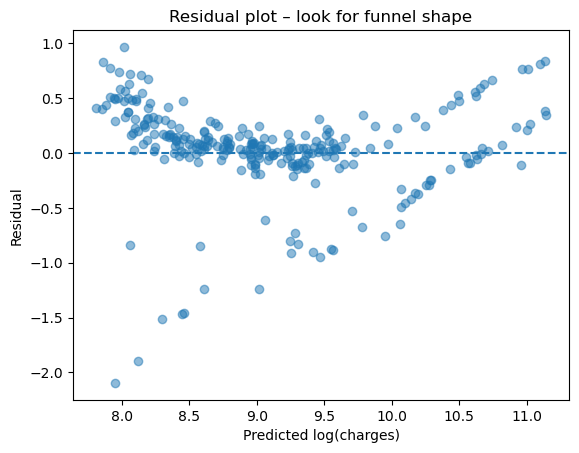

In [55]:
# Inspect residuals

#   • Each dot = one patient.
#   • X-axis  : the model’s predicted log(charges).
#   • Y-axis  : the error (= prediction − truth). Zero means perfect.
#
# Why look at it?
#   1. We want the dots to form a random, flat “cloud” around the 0 line.
#   2. A **funnel shape** (errors getting wider as predictions grow)
#      ⇒ variance is not constant ⇒ linear-regression assumptions are violated.
#   3. A clear curve or slope ⇒ the relationship isn’t truly linear
#      (maybe add interaction terms or switch to a non-linear model).
#
# Bottom line: this quick visual check tells you whether the straight-line
# model is behaving reasonably or if there are pattern-of-error red flags.
resid = log_pred - y_test
plt.scatter(log_pred, resid, alpha = 0.5)
plt.axhline(0, ls='--')
plt.xlabel("Predicted log(charges)")
plt.ylabel("Residual")
plt.title("Residual plot – look for funnel shape")
plt.show()

In [62]:
# Build a new pipeline

# ↳ `PolynomialFeatures`
#     • degree=2  → adds squares & pairwise interactions
#       (x₁², x₂², x₁·x₂, …) so a *linear* model can capture
#       gentle curves and feature interactions.
#     • include_bias=False  → don’t add an all-ones column;
#       Ridge already learns its own intercept.
#
# ↳ `Ridge`
#     • Ordinary Least Squares + L2 penalty (α‖w‖²).
#     • Shrinks large coefficients ⇒ less over-fit, more stable
#       when poly terms create collinearity.
poly_ridge = Pipeline([
    ('prep',preprocess),('poly',PolynomialFeatures(degree=2,include_bias=False)),('ridge',Ridge())])

In [69]:
# Set up a grid of alpha (penalty strength) values to try
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

In [70]:
# Cross-validate to find the best alpha
grid = GridSearchCV(
    estimator=poly_ridge, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
# Note: When using GridSearchCV with cv=6,
# the dataset is split into 6 fixed folds only once.
# For each parameter value (e.g., each alpha),
# the model is trained and validated using the same 6 folds.
# It rotates which fold is used as the validation set,
# but the data inside each fold stays the same across all parameter trials.
# This ensures a fair and consistent comparison between different parameters.

In [72]:
# Fit on TRAIN data only
grid.fit(X_train,y_train)
# Returns the full model trained with the best parameter setting
best_model = grid.best_estimator_
print("Best alpha:", grid.best_params_['ridge__alpha'])

Best alpha: 1


In [73]:
# Evaluate and visualize again
log_pred_poly = best_model.predict(X_test)

In [75]:
# Metrics in log space
print("R² (log):", r2_score(y_test, log_pred_poly))
print("RMSE (log):", mean_squared_error(y_test, log_pred_poly,squared=False))

# Convert back to dollar
y_test_dollar = np.expm1(y_test)
pred_dollar = np.expm1(log_pred_poly)
print("MAE ($):",  mean_absolute_error(y_test_dollar, pred_dollar))
print("RMSE ($):", mean_squared_error(y_test_dollar, pred_dollar, squared=False))

R² (log): 0.8646556708694456
RMSE (log): 0.34879031697944163
MAE ($): 2398.017623678409
RMSE ($): 4733.4794528205075


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


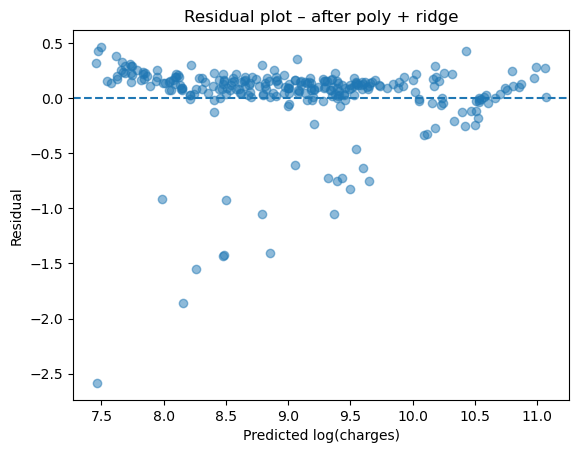

In [76]:
# residual plot
resid = log_pred_poly - y_test
plt.scatter(log_pred_poly, resid, alpha=0.5)
plt.axhline(0, ls='--')
plt.xlabel("Predicted log(charges)")
plt.ylabel("Residual")
plt.title("Residual plot – after poly + ridge")
plt.show()

In [78]:
# Intepret new coefficients
ridge_step = best_model.named_steps['ridge']
poly_step = best_model.named_steps['poly']
feature_names = poly_step.get_feature_names_out(best_model.named_steps['prep'].get_feature_names_out())

coef_table = (pd.Series(ridge_step.coef_,index=feature_names).sort_values(key=abs,ascending=False).head(15))
print(coef_table)

cat__smoker_yes^2                        0.688948
cat__smoker_yes                          0.688948
num__age                                 0.455207
cat__smoker_yes num__age                -0.454813
cat__smoker_yes num__bmi                 0.301521
cat__smoker_yes cat__region_southwest    0.218806
num__children                            0.181141
cat__smoker_yes num__children           -0.153508
cat__region_southwest num__age           0.129315
cat__region_southeast num__age           0.108365
cat__sex_male cat__smoker_yes            0.106593
cat__region_southwest^2                 -0.103327
cat__region_southwest                   -0.103327
cat__region_southeast                   -0.082937
cat__region_southeast^2                 -0.082937
dtype: float64


In [80]:
joblib.dump(best_model, 'charges_poly_ridge.joblib')

['charges_poly_ridge.joblib']

In [82]:
def predict_charges(raw_df):
    """Takes a raw DataFrame like the original CSV and
       returns predicted charges ($)."""
    log_preds = best_model.predict(raw_df)
    return np.expm1(log_preds)